In [1]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential, model_from_json
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5005)


In [2]:
import math

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
from python_speech_features import fbank, logfbank

from scipy.ndimage.interpolation import shift
from scipy.signal import spectrogram

from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

import soundfile

from onset_detection.metrics import onset_metric
from onset_detection.read_data import read_data

# Spectrogram tests

In [13]:
samples, sample_rate = soundfile.read(r'data\IDMT-SMT-GUITAR_V2\dataset2\audio\AR_Lick10_KN.wav')
print(samples.shape)
print(sample_rate)

(706816,)
44100


(129,)
(3155,)
(129, 3155)


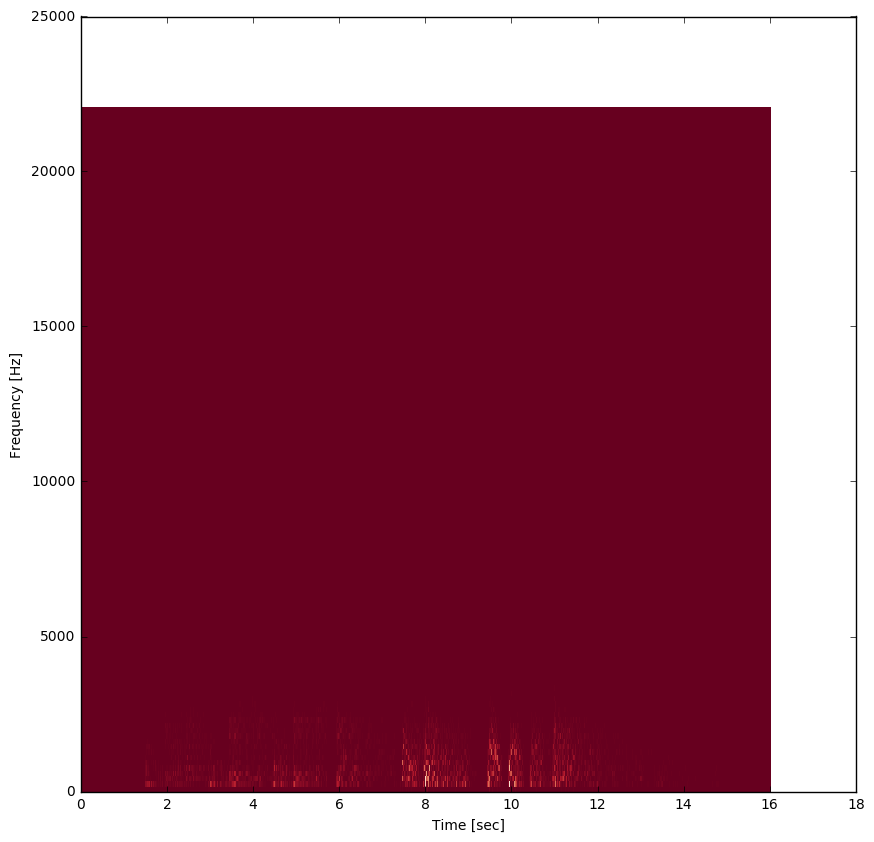

In [26]:
f, t, Sxx = spectrogram(np.absolute(samples), sample_rate)
print(f.shape)
print(t.shape)
print(Sxx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, Sxx, cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

(129,)
[     0.          172.265625    344.53125     516.796875    689.0625
    861.328125   1033.59375    1205.859375   1378.125      1550.390625
   1722.65625    1894.921875   2067.1875     2239.453125   2411.71875
   2583.984375   2756.25       2928.515625   3100.78125    3273.046875
   3445.3125     3617.578125   3789.84375    3962.109375   4134.375
   4306.640625   4478.90625    4651.171875   4823.4375     4995.703125
   5167.96875    5340.234375   5512.5        5684.765625   5857.03125
   6029.296875   6201.5625     6373.828125   6546.09375    6718.359375
   6890.625      7062.890625   7235.15625    7407.421875   7579.6875
   7751.953125   7924.21875    8096.484375   8268.75       8441.015625
   8613.28125    8785.546875   8957.8125     9130.078125   9302.34375
   9474.609375   9646.875      9819.140625   9991.40625   10163.671875
  10335.9375    10508.203125  10680.46875   10852.734375  11025.
  11197.265625  11369.53125   11541.796875  11714.0625    11886.328125
  12058.59375  

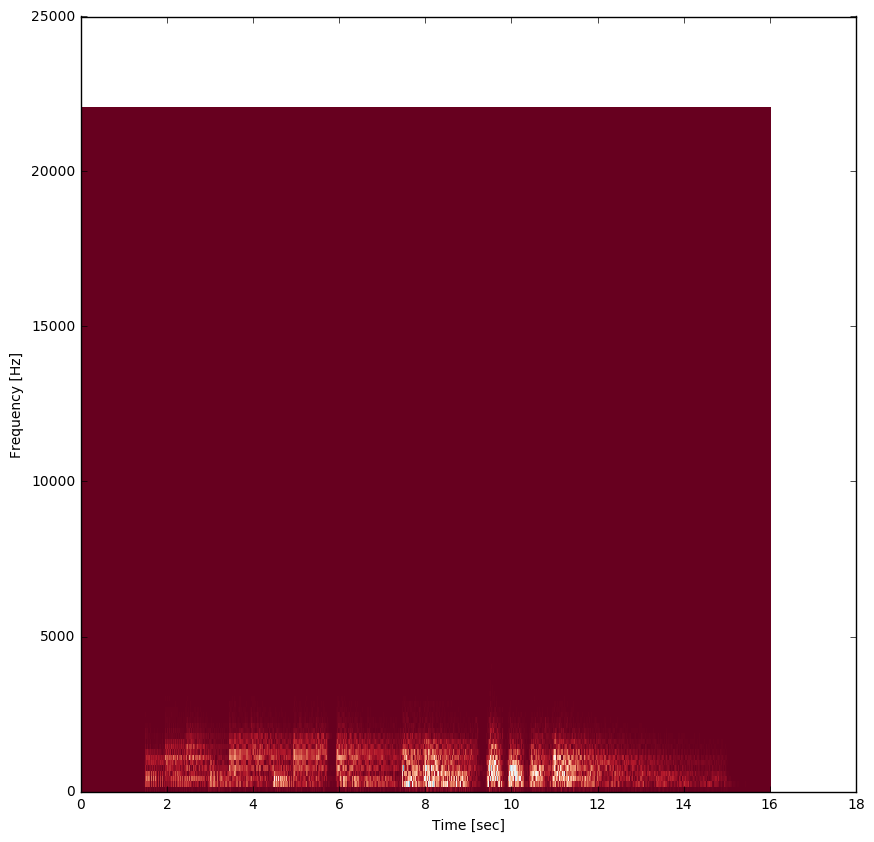

In [29]:
f, t, Sxx = spectrogram(samples, sample_rate, mode='magnitude')
print(f.shape)
print(f)
print(t.shape)
print(t)
print(Sxx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, Sxx, cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

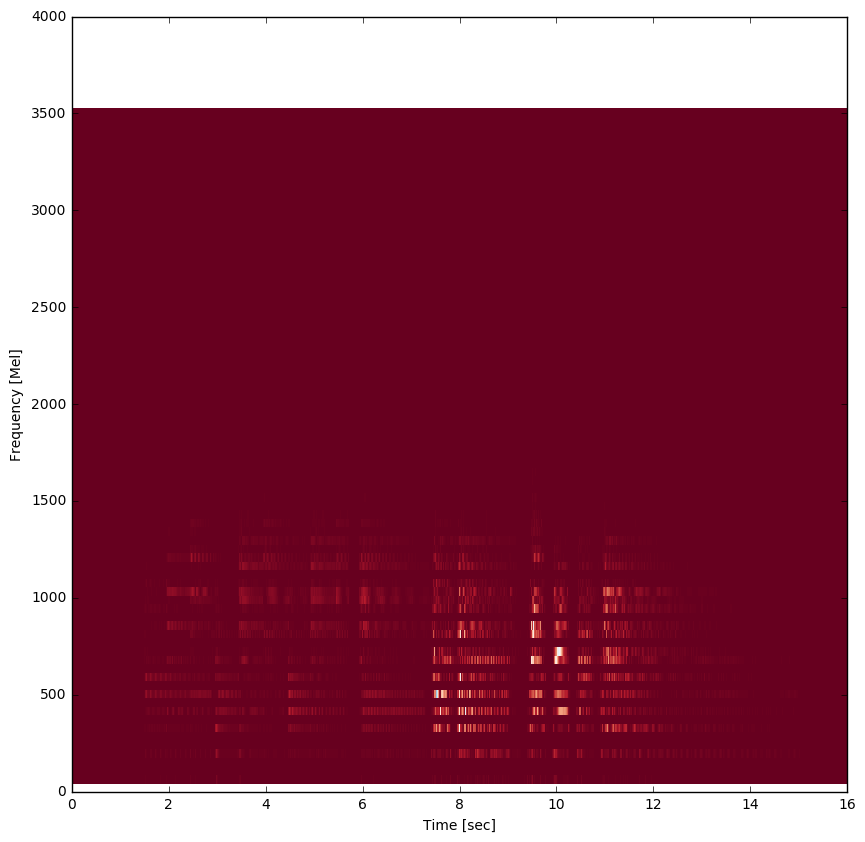

In [17]:
def to_mel(freq):
    return 1125 * math.log(1 + freq/700)

winlen = 0.046
winstep = 0.01
lowfreq = 27.5
highfreq = 16000
# features, _ = fbank(samples, sample_rate, nfilt=80)
features, _ = fbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=80, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
# features = logfbank(samples, sample_rate, winstep=winstep, nfilt=80, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
t_len, f_len = features.shape
mel_lowfreq = to_mel(lowfreq)
mel_highfreq = to_mel(highfreq)
f = np.arange(mel_lowfreq, mel_highfreq, (mel_highfreq - mel_lowfreq)/f_len)
t = np.arange(0.0, t_len*winstep, winstep)

plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, features.T, cmap='RdBu')
plt.ylabel('Frequency [Mel]')
plt.xlabel('Time [sec]')

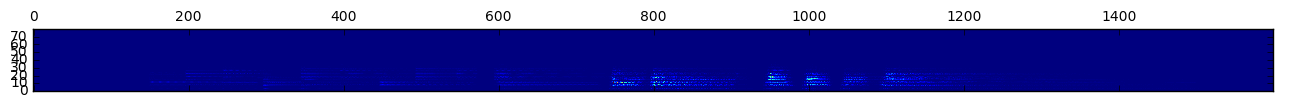

In [58]:
plt.matshow(features.T, origin='lower')

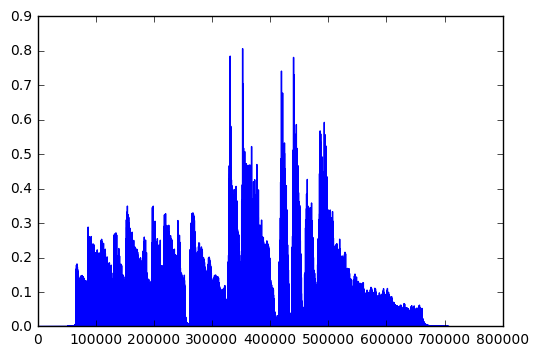

In [19]:
plt.plot(np.absolute(samples))

In [2]:
samples, sample_rate = soundfile.read(r'data\IDMT-SMT-GUITAR_V2\dataset2\audio\LP_Lick8_KN.wav')
print(samples.shape)
print(sample_rate)

(657232,)
44100


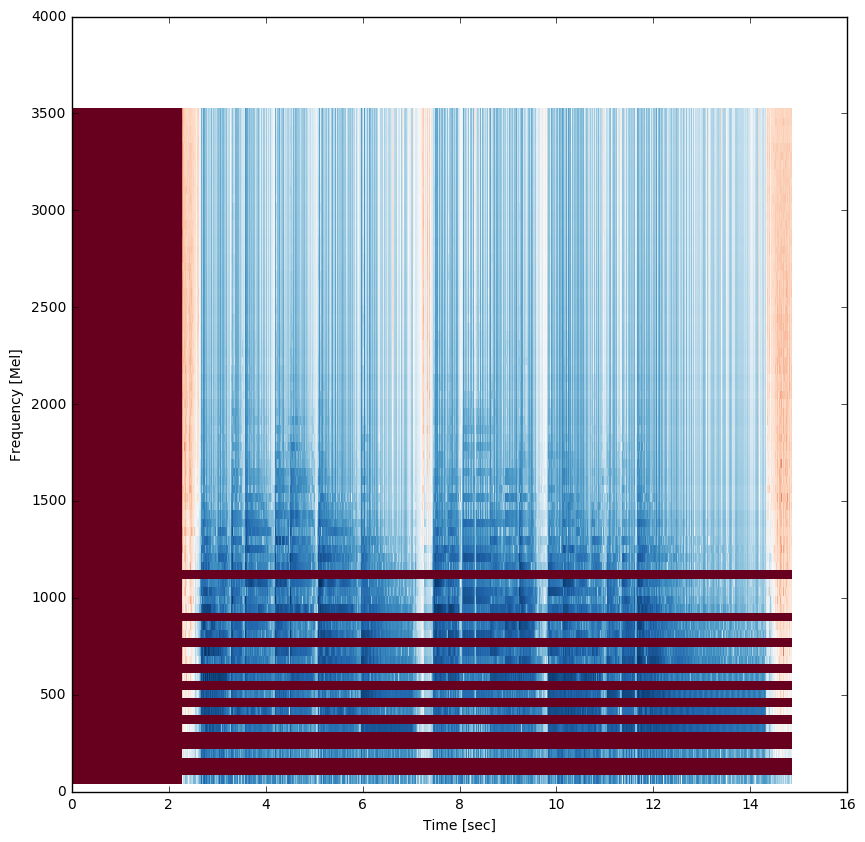

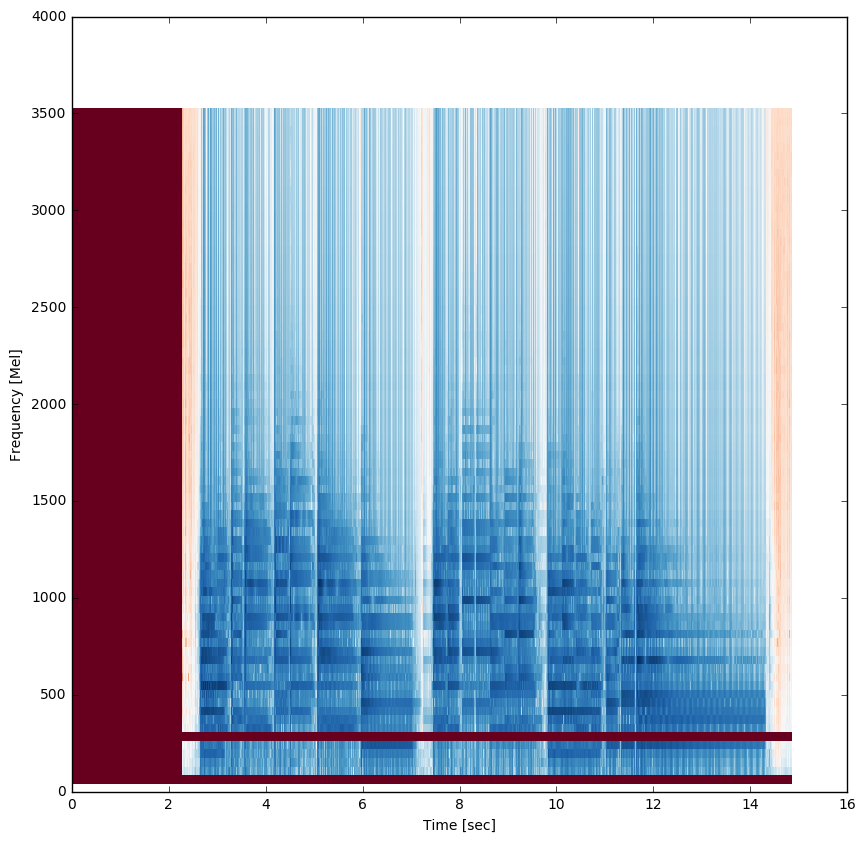

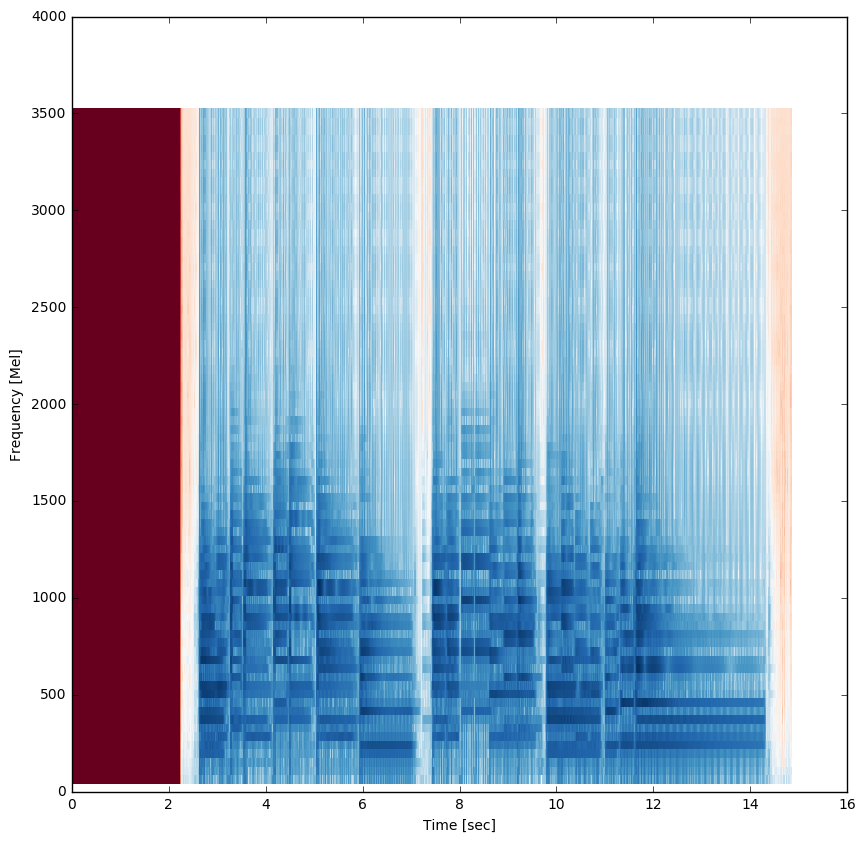

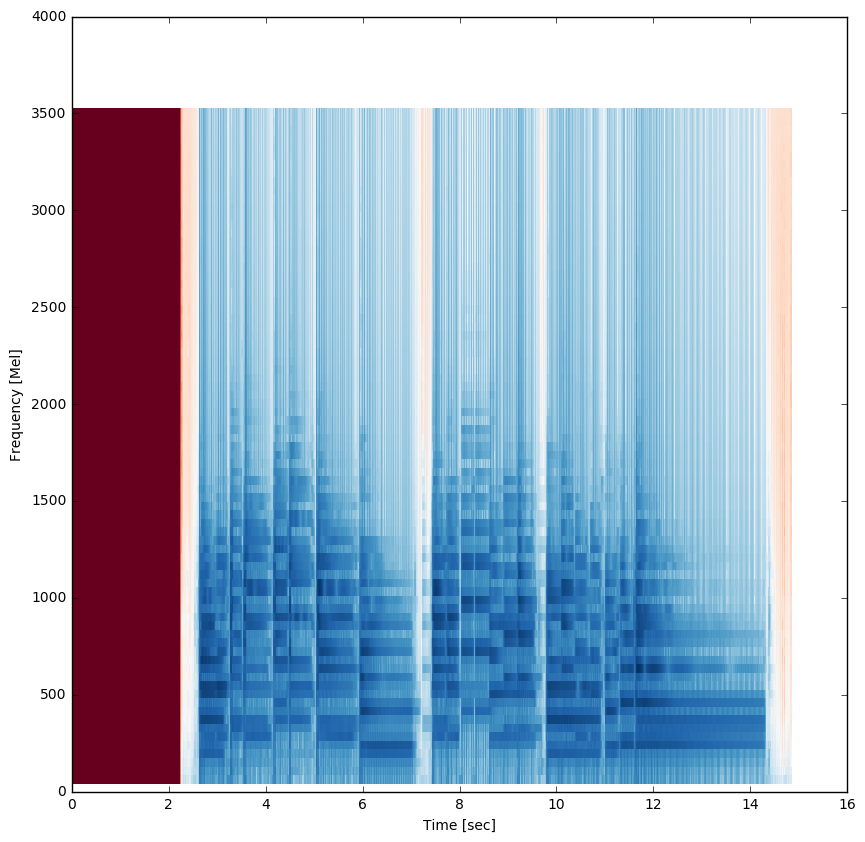

In [8]:
def to_mel(freq):
    return 1125 * math.log(1 + freq/700)

winlen = 0.046
winstep = 0.01
lowfreq = 27.5
highfreq = 16000

for nfft in [512, 1024, 2048, 4096]:
    # features, _ = fbank(samples, sample_rate, nfilt=80)
    # features, _ = fbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=80, nfft=nfft, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
    features = logfbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=80, nfft=nfft, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
    t_len, f_len = features.shape
    mel_lowfreq = to_mel(lowfreq)
    mel_highfreq = to_mel(highfreq)
    f = np.arange(mel_lowfreq, mel_highfreq, (mel_highfreq - mel_lowfreq)/f_len)
    t = np.arange(0.0, t_len*winstep, winstep)

    plt.figure(figsize=(10,10))
    plt.pcolormesh(t, f, features.T, cmap='RdBu')
    plt.ylabel('Frequency [Mel]')
    plt.xlabel('Time [sec]')

In [45]:
for j in range(features.shape[1]):
    print(str(j) + ' ' + str(features[:, j].mean()))

0 0.00846905107682
1 0.012509268175
2 0.109920004448
3 0.121226440889
4 2.22044604925e-16
5 0.124424883045
6 0.229177569573
7 0.167832682587
8 0.0989874644363
9 0.0760293318726
10 0.162408544505
11 0.0779480567678
12 0.125057948133
13 0.0604417465413
14 0.0279902610011
15 0.0119065347092
16 0.00505722484522
17 0.00288380917565
18 0.00180589753228
19 0.00113410473765
20 0.000742650644601
21 0.000691578039833
22 0.000510261579023
23 0.00038534596173
24 0.000356908464057
25 0.000289757144556
26 0.000242126201982
27 0.000229476285399
28 0.000235264929197
29 0.000198254305356
30 0.000181491678347
31 0.00016862104101
32 0.00014440376332
33 0.000143692758428
34 0.000132544087732
35 0.000122410588463
36 0.000113758089678
37 0.000110590088998
38 0.000102924919833
39 9.60875321525e-05
40 9.83139374522e-05
41 9.60516157077e-05


In [47]:
for j in range(features.shape[1]):
    print(str(j) + ' ' + str(features[:, j].mean()))

0 0.00846905107682
1 0.012509268175
2 0.109920004448
3 0.121226440889
4 0.124424883045
5 0.178417774877
6 0.10151958939
7 0.117072887892
8 0.0989874644363
9 0.143134764722
10 0.123500790462
11 0.105867326086
12 0.0817650518943
13 0.0476176946562
14 0.0279902610011
15 0.0119065347092
16 0.0058628537748
17 0.00283804582149
18 0.00161800356748
19 0.001031534069
20 0.000705041533134
21 0.000499324204019
22 0.000445479987077
23 0.000398975061579
24 0.000320452602069
25 0.000293064046532
26 0.000268355969962
27 0.000223720753439
28 0.000206707036796
29 0.000190167200047
30 0.000162017477958
31 0.000161561686359
32 0.000148715292673
33 0.00013572493359
34 0.000132509133194
35 0.000115403276522
36 0.000106881414547
37 0.000109093427884
38 0.000105552124339
39 9.83139374522e-05
40 9.60516157077e-05


# 2D ConvNet

In [3]:
def transform_X(X_part, n_frames, frame_rate_hz, sample_rate, log_transform_magnitudes=True,
                winlen=0.046, nfilt=80, nfft=2048,
                lowfreq=27.5, highfreq=16000, preemph=0):
    """Last (winlen - winstep) seconds will be cut off"""
    
    winstep = 1 / frame_rate_hz
    samples = X_part.ravel()
    if log_transform_magnitudes:
        filterbank = logfbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=nfilt,
                              nfft=nfft, lowfreq=lowfreq, highfreq=highfreq, preemph=preemph)
    else:
        filterbank, _ = fbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=nfilt,
                              nfft=nfft, lowfreq=lowfreq, highfreq=highfreq, preemph=preemph)
    
    if n_frames is None:
        n_frames = filterbank.shape[0]
    return filterbank[:n_frames, :], n_frames

def transform_labels(y_part, y_actual_onset_only_part, ds_label, n_frames):
    ds_labels_part = np.empty(n_frames, dtype=np.int8)
    ds_labels_part.fill(ds_label)
    return y_part[:n_frames], y_actual_onset_only_part[:n_frames], ds_labels_part

def transform_all(X_parts, y_parts, y_actual_onset_only_parts, ds_labels, frame_rate_hz, sample_rate):
    n_frames_list = [None] * len(X_parts)
    X_channels = []
    # Create 3 channels with different window length.
    # Make sure to run the largest window first which cuts off the most at the end of the file.
    # Return and reuse the number of frames for each part = each file for the other nfft values.
    for winlen, nfft in sorted(
        # [(0.023, 1024), (0.046, 2048), (0.092, 4096)],
        [(0.046, 2048)],
        
        key=lambda t: t[1], reverse=True
    ):
        transformed = [transform_X(X_part, n_frames, frame_rate_hz, sample_rate, winlen=winlen, nfft=nfft)
                       for X_part, n_frames
                       in zip(X_parts, n_frames_list)]
        X = np.concatenate([t[0] for t in transformed])
        n_frames_list = [t[1] for t in transformed]
        X_channels.append(X)
    
    transformed = [transform_labels(y_part, y_actual_onset_only_part, ds_label, n_frames)
                   for y_part, y_actual_onset_only_part, ds_label, n_frames
                   in zip(y_parts, y_actual_onset_only_parts, ds_labels, n_frames_list)]
    y = np.concatenate([t[0] for t in transformed])
    y_actual_onset_only = np.concatenate([t[1] for t in transformed])
    ds_labels_flat = np.concatenate([t[2] for t in transformed])
    
    return X_channels, y, y_actual_onset_only, ds_labels_flat

def get_X_with_context_frames(X, c=7, border_value=0.0):
    """Return new X with new dimensions (X.shape[0] = n_samples, 2*c + 1, X.shape[1] = filterbank_size)
    
    One entry of X_new consists of c frames of context before the current frame,
    the current frame and another c frames of context after the current frame.
    """
    
    n_samples = X.shape[0]
    filterbank_size = X.shape[1]
    X_new = np.empty((n_samples, 2*c + 1, filterbank_size))
    for i in range(n_samples):
        for offset in range(-c, c + 1):
            if i + offset > -1 and i + offset < n_samples:
                # X_new 2nd dim: [0, 2*c + 1[
                # X 1st dim: [i-c, i+c+1[
                X_new[i, offset + c, :] = X[i + offset, :]
            else:
                X_new[i, offset + c].fill(border_value)
    return X_new

def create_model(input_shape):
    model = Sequential()
    # Kernel size and pool size should be correct this way but better compare the results both ways ((7, 3) vs (3, 7)).
    model.add(Conv2D(10, (7, 3), padding='valid', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 3)))
    model.add(Conv2D(20, (3, 3), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, 3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def prepare_data(
    X_parts_train, y_parts_train, y_actual_onset_only_parts_train, ds_labels_train,
    X_parts_test, y_parts_test, y_actual_onset_only_parts_test, ds_labels_test,
    frame_rate_hz, sample_rate
):
    print('Creating spectrograms')
    X_channels_train, y_train, y_actual_onset_only_train, ds_labels_flat_train = transform_all(
        X_parts_train, y_parts_train, y_actual_onset_only_parts_train, ds_labels_train, frame_rate_hz, sample_rate
    )
    X_channels_test, y_test, y_actual_onset_only_test, ds_labels_flat_test = transform_all(
        X_parts_test, y_parts_test, y_actual_onset_only_parts_test, ds_labels_test, frame_rate_hz, sample_rate
    )
    
    print('Spectrogram data infos:')
    for X_channels, y, y_actual_onset_only, ds_labels_flat in [
        (X_channels_train, y_train, y_actual_onset_only_train, ds_labels_flat_train),
        (X_channels_test, y_test, y_actual_onset_only_test, ds_labels_flat_test),
    ]:
        for X in X_channels:
            print(X.shape)
        print(y.shape)
        print(y.sum())
        print(y_actual_onset_only.shape)
        print(y_actual_onset_only.sum())
        print(ds_labels_flat.shape)
        print(ds_labels_flat.mean())
    for X_train, X_test in zip(X_channels_train, X_channels_test):
        print(X_train.shape)
        print(X_test.shape)
        print(X_train.mean())
        print(X_train.std())
        print(X_test.mean())
        print(X_test.std())
        print('')
    
    print('Standardizing (each band separately)')
    for X_train, X_test in zip(X_channels_train, X_channels_test):
        for j in range(X_train.shape[1]):
            ss = StandardScaler()
            X_train[:, j:j+1] = ss.fit_transform(X_train[:, j:j+1])
            X_test[:, j:j+1] = ss.transform(X_test[:, j:j+1])
    
    print('Data after standardizing:')
    for X_train, X_test in zip(X_channels_train, X_channels_test):
        print(X_train.shape)
        print(X_test.shape)
        print(X_train.mean())
        print(X_train.std())
        print(X_test.mean())
        print(X_test.std())
        print('')
    for i in range(len(X_channels_train)):
        X_channels_train[i] = get_X_with_context_frames(X_channels_train[i])
        X_channels_test[i] = get_X_with_context_frames(X_channels_test[i])
        print(X_channels_train[i].shape)
        print(X_channels_test[i].shape)
    
    print('Reshaping data')
    img_rows, img_cols = (X_channels_train[0].shape[1], X_channels_train[0].shape[2])
    for i in range(len(X_channels_train)):
        # Theano is 3 times faster with channels_first vs. channels_last on MNIST, so this setting matters.
        # "image_data_format": "channels_first" @ %USERPROFILE%/.keras/keras.json
        if K.image_data_format() == 'channels_first':
            X_channels_train[i] = X_channels_train[i].reshape(X_channels_train[i].shape[0], 1, img_rows, img_cols)
            X_channels_test[i] = X_channels_test[i].reshape(X_channels_test[i].shape[0], 1, img_rows, img_cols)
        else:
            X_channels_train[i] = X_channels_train[i].reshape(X_channels_train[i].shape[0], img_rows, img_cols, 1)
            X_channels_test[i] = X_channels_test[i].reshape(X_channels_test[i].shape[0], img_rows, img_cols, 1)
        print(X_channels_train[i].shape)
        print(X_channels_test[i].shape)

    if K.image_data_format() == 'channels_first':
        input_shape = (len(X_channels_train), img_rows, img_cols)
    else:
        input_shape = (img_rows, img_cols, len(X_channels_train))
    print(input_shape)
    
    print('Concatenating channels')
    X_train = np.concatenate(X_channels_train, axis=1)
    X_test = np.concatenate(X_channels_test, axis=1)
    print(X_train.shape)
    print(X_test.shape)
    
    return (X_train, y_train, y_actual_onset_only_train, ds_labels_flat_train,
            X_test, y_test, y_actual_onset_only_test, ds_labels_flat_test,
            input_shape)

def fit_predict(X_train, y_train, y_actual_onset_only_train, X_test, y_test, y_actual_onset_only_test, input_shape):
    clf = KerasClassifier(
        build_fn=create_model,
        batch_size=1024, epochs=500,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='loss', patience=5)],
        input_shape=input_shape
    )
    clf.fit(X_train, y_train, verbose=2)
    y_train_predicted = clf.predict(X_train).ravel()
    y_test_predicted = clf.predict(X_test).ravel()

    model = clf.model
    # for layer in model.layers:
        # print('layer config:')
        # print(layer.get_config())
        # print('input shape: ' + str(layer.input_shape))
        # print('output shape: ' + str(layer.output_shape))
    print('TRAIN')
    print(classification_report(y_train, y_train_predicted))
    print(onset_metric(y_train, y_actual_onset_only_train, y_train_predicted, n_tolerance_frames_plus_minus=2))
    print(onset_metric(y_train, y_actual_onset_only_train, y_train_predicted, n_tolerance_frames_plus_minus=5))
    print('TEST')
    print(classification_report(y_test, y_test_predicted))
    print(onset_metric(y_test, y_actual_onset_only_test, y_test_predicted, n_tolerance_frames_plus_minus=2))
    print(onset_metric(y_test, y_actual_onset_only_test, y_test_predicted, n_tolerance_frames_plus_minus=5))
    print('')
    
    return clf

In [4]:
# active_datasets = {1, 2, 3, 4}
# active_datasets = {2}
# active_datasets = {4}
active_datasets = {1, 2}
frame_rate_hz = 100
expected_sample_rate = 44100
subsampling_step = 1
X_parts, y_parts, y_actual_onset_only_parts, ds_labels = read_data(
    active_datasets, frame_rate_hz, expected_sample_rate, subsampling_step
)

D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:187: UserWarning: Skipping AR_Lick11_FN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:187: UserWarning: Skipping AR_Lick11_KN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:187: UserWarning: Skipping AR_Lick11_MN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:189: UserWarning: Skipping data\IDMT-SMT-GUITAR_V2\dataset2\audio\desktop.ini, not a .wav file.
  warn('Skipping ' + path_to_wav + ', not a .wav file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:187: UserWarning: Skipping FS_Lick11_FN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
D:\Users\Michel\

## Fit / predict

In [ ]:
X_parts_train, X_parts_test, y_parts_train, y_parts_test, y_actual_onset_only_parts_train, y_actual_onset_only_parts_test, ds_labels_train, ds_labels_test = train_test_split(
    X_parts, y_parts, y_actual_onset_only_parts, ds_labels, test_size=0.2, random_state=42
)
X_parts = None
y_parts = None
y_actual_onset_only_parts = None
ds_labels = None

(
    X_train, y_train, y_actual_onset_only_train, ds_labels_flat_train,
    X_test, y_test, y_actual_onset_only_test, ds_labels_flat_test,
    input_shape
) = prepare_data(
    X_parts_train, y_parts_train, y_actual_onset_only_parts_train, ds_labels_train,
    X_parts_test, y_parts_test, y_actual_onset_only_parts_test, ds_labels_test,
    frame_rate_hz, expected_sample_rate
)
X_parts_train = None
X_parts_test = None
y_parts_train = None
y_parts_test = None
y_actual_onset_only_parts_train = None
y_actual_onset_only_parts_test = None
ds_labels_train = None
ds_labels_test = None

clf = fit_predict(X_train, y_train, y_actual_onset_only_train, X_test, y_test, y_actual_onset_only_test, input_shape)

## CV on dataset 1 + 2

In [5]:
ds12 = [t for t
        in zip(X_parts, y_parts, y_actual_onset_only_parts, ds_labels) if t[3] == 1 or t[3] == 2]
# ds34 = [t for t
#         in zip(X_parts, y_parts, y_actual_onset_only_parts, ds_labels) if t[3] != 1 and t[3] != 2]
X_parts = None
y_parts = None
y_actual_onset_only_parts = None
ds_labels = None

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
clfs = []
for train_indices, test_indices in k_fold.split(ds12):
    X_parts_train = [t[0] for t in [ds12[i] for i in train_indices]]#  + [t[0] for t in ds34]
    y_parts_train = [t[1] for t in [ds12[i] for i in train_indices]]#  + [t[1] for t in ds34]
    y_actual_onset_only_parts_train = [t[2] for t in [ds12[i] for i in train_indices]]#  + [t[2] for t in ds34]
    ds_labels_train = [t[3] for t in [ds12[i] for i in train_indices]]#  + [t[3] for t in ds34]
    X_parts_test = [t[0] for t in [ds12[i] for i in test_indices]]
    y_parts_test = [t[1] for t in [ds12[i] for i in test_indices]]
    y_actual_onset_only_parts_test = [t[2] for t in [ds12[i] for i in test_indices]]
    ds_labels_test = [t[3] for t in [ds12[i] for i in test_indices]]
    
    (
        X_train, y_train, y_actual_onset_only_train, ds_labels_flat_train,
        X_test, y_test, y_actual_onset_only_test, ds_labels_flat_test,
        input_shape
    ) = prepare_data(
        X_parts_train, y_parts_train, y_actual_onset_only_parts_train, ds_labels_train,
        X_parts_test, y_parts_test, y_actual_onset_only_parts_test, ds_labels_test,
        frame_rate_hz, expected_sample_rate
    )
    X_parts_train = None
    X_parts_test = None
    y_parts_train = None
    y_parts_test = None
    y_actual_onset_only_parts_train = None
    y_actual_onset_only_parts_test = None
    ds_labels_train = None
    ds_labels_test = None

    clf = fit_predict(X_train, y_train, y_actual_onset_only_train, X_test, y_test, y_actual_onset_only_test, input_shape)
    clfs.append(clf)

Creating spectrograms
Spectrogram data infos:
(354959, 80)
(354959,)
10706
(354959,)
3803
(354959,)
1.78630207996
(86329, 80)
(86329,)
2159
(86329,)
775
(86329,)
1.76515423554
(354959, 80)
(86329, 80)
-12.4376983605
6.44601379577
-12.6196319939
6.65364390715

Standardizing (each band separately)
Data after standardizing:
(354959, 80)
(86329, 80)
-1.73592629135e-16
1.0
-0.0303297910017
1.03965938446

(354959, 15, 80)
(86329, 15, 80)
Reshaping data
(354959, 1, 15, 80)
(86329, 1, 15, 80)
(1, 15, 80)
Concatenating channels
(354959, 1, 15, 80)
(86329, 1, 15, 80)
Train on 354959 samples, validate on 86329 samples
Epoch 1/500
11s - loss: 0.0577 - acc: 0.9799 - val_loss: 0.0346 - val_acc: 0.9864
Epoch 2/500
10s - loss: 0.0366 - acc: 0.9851 - val_loss: 0.0315 - val_acc: 0.9876
Epoch 3/500
11s - loss: 0.0341 - acc: 0.9863 - val_loss: 0.0266 - val_acc: 0.9887
Epoch 4/500
11s - loss: 0.0318 - acc: 0.9870 - val_loss: 0.0251 - val_acc: 0.9891
Epoch 5/500
11s - loss: 0.0306 - acc: 0.9876 - val_loss: 

# Save / load

In [18]:
def save_model(model, path_to_json='model.json', path_to_weights='weights.hdf5'):
    with open(path_to_json, 'w') as f:
        f.write(model.to_json())
    model.save_weights(path_to_weights)

def load_model(path_to_json='model.json', path_to_weights='weights.hdf5'):
    with open(path_to_json) as f:
        model = model_from_json(f.read())
    model.load_weights(path_to_weights)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# currently impossible without custom mods: https://github.com/fchollet/keras/issues/4274
# def load_model_sklearn(path_to_json='model.json', path_to_weights='weights.hdf5'):
#     clf = KerasClassifier(
#         build_fn=load_model,
#         batch_size=1024, epochs=500,
#         path_to_json=path_to_json, path_to_weights=path_to_weights,
#     )
#     
#     return clf

In [19]:
save_model(model, path_to_json='models/20170423_1_channel_ds1-4.json', path_to_weights='models/20170423_1_channel_ds1-4.hdf5')

In [20]:
loaded_model = load_model(path_to_json='models/20170423_1_channel_ds1-4.json', path_to_weights='models/20170423_1_channel_ds1-4.hdf5')

In [21]:
print(loaded_model.evaluate(X_test, y_test, batch_size=1024))

230400/231210 [============================>.] - ETA: 0s[0.052954115933474773, 0.98060205009722867]


In [22]:
y_test_predicted = loaded_model.predict_classes(X_test, batch_size=1024).ravel()
print(classification_report(y_test, y_test_predicted))
print(onset_metric(y_test, y_actual_onset_only_test, y_test_predicted, n_tolerance_frames_plus_minus=2))
print(onset_metric(y_test, y_actual_onset_only_test, y_test_predicted, n_tolerance_frames_plus_minus=5))

230400/231210 [============================>.] - ETA: 0s             precision    recall  f1-score   support

          0       0.99      0.99      0.99    217041
          1       0.84      0.85      0.84     14169

avg / total       0.98      0.98      0.98    231210

TP=4730, FN=117, FP=530
precision=0.899239543726, recall=0.9758613575407469, F1=0.935984960918

TP=4760, FN=87, FP=143
precision=0.970834183153, recall=0.9820507530431195, F1=0.97641025641



# Find offset of onset detection labeling per dataset

In [22]:
for name, X, y, y_actual_onset_only in [
    ('ds1', X_ds1, y_ds1, y_actual_onset_only_ds1),
    ('ds2', X_ds2, y_ds2, y_actual_onset_only_ds2),
    ('ds3', X_ds3, y_ds3, y_actual_onset_only_ds3),
]:
    print(name)
    y_predicted = loaded_model.predict_classes(X, batch_size=1024).ravel()
    for shift_by in range(-5, 6):
        print(shift_by)
        y_shifted = shift(y, shift_by, cval=0)
        y_actual_onset_only_shifted = shift(y_actual_onset_only, shift_by, cval=0)
        print(classification_report(y_shifted, y_predicted))
        print(onset_metric(y_shifted, y_actual_onset_only_shifted, y_predicted, n_tolerance_frames_plus_minus=2))
        print(onset_metric(y_shifted, y_actual_onset_only_shifted, y_predicted, n_tolerance_frames_plus_minus=5))
    print('')

ds1
95232/96128 [============================>.] - ETA: 0s-5
             precision    recall  f1-score   support

          0       0.98      0.99      0.99     94123
          1       0.27      0.21      0.24      2005

avg / total       0.97      0.97      0.97     96128

TP=366, FN=423, FP=1096
precision=0.250341997264, recall=0.46387832699619774, F1=0.325188804976

TP=776, FN=13, FP=217
precision=0.781470292044, recall=0.9835234474017744, F1=0.870931537598

-4
             precision    recall  f1-score   support

          0       0.98      0.99      0.99     94123
          1       0.30      0.24      0.26      2005

avg / total       0.97      0.97      0.97     96128

TP=546, FN=243, FP=901
precision=0.377332411887, recall=0.6920152091254753, F1=0.488372093023

TP=780, FN=9, FP=53
precision=0.93637454982, recall=0.9885931558935361, F1=0.961775585697

-3
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     94123
          1       0

# Visualization

In [23]:
print(loaded_model.layers[0].get_weights()[0].shape)

(7, 3, 1, 10)


In [24]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

(10, 7, 3)


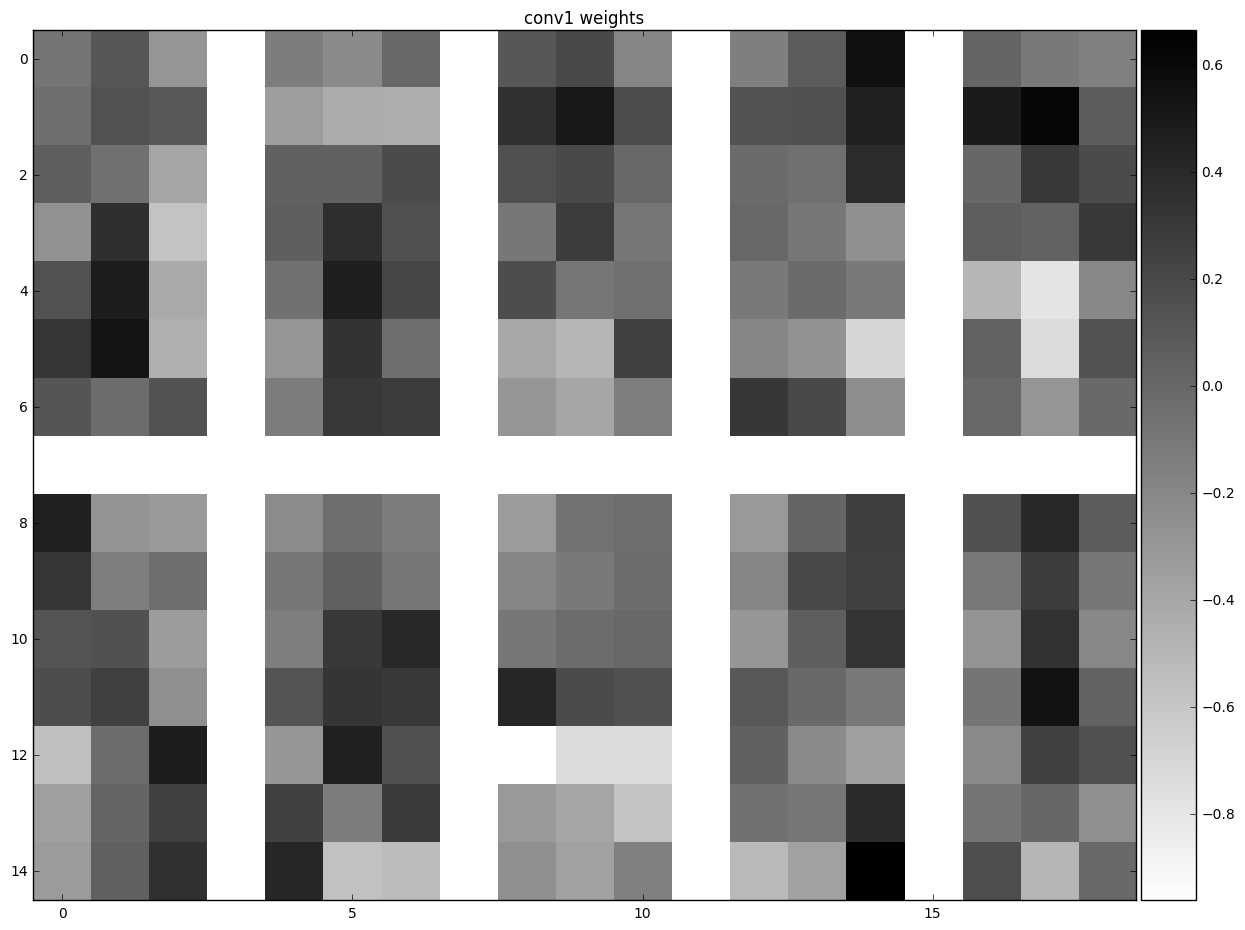

In [25]:
# Visualize weights
W = loaded_model.layers[0].get_weights()[0]
# (7, 3, 1, 10) -> (10, 3, 7)
W = np.squeeze(W).T
# (10, 3, 7) -> (10, 7, 3)
W_filters_transposed = np.empty((W.shape[0], W.shape[2], W.shape[1]))
for i, array in enumerate(W):
    W_filters_transposed[i] = array.T
print(W_filters_transposed.shape)

plt.figure(figsize=(15, 15))
plt.title('conv1 weights')
nice_imshow(plt.gca(), make_mosaic(W_filters_transposed, 2, 5), cmap=cm.binary)
# nice_imshow(plt.gca(), make_mosaic(W_filters_transposed, 4, 4), cmap=cm.binary)